In [1]:
%load_ext google.cloud.bigquery
%load_ext tensorboard
import os
import pandas as pd
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="gcloud-credentials.json"

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information form over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 12 years ago. So if today is 2021.02.15 then the weather we want to forecast is for the date 2009.02.16. You are suppsed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to used BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is, to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck at the first part, you can use the replacement data provided in the second part

In [2]:
%%bigquery
SELECT
*,
FROM `bigquery-public-data.samples.gsod`
LIMIT 20 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.59rows/s]


,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,31590,99999,1930,8,2,56.000000,4,55.000000,4.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
1,726810,24131,1931,7,3,71.099998,24,39.200001,8.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
2,726810,24131,1931,4,13,52.700001,24,38.400002,7.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
3,726810,24131,1931,12,25,40.400002,24,34.599998,8.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
4,726810,24131,1931,12,8,30.100000,24,27.600000,8.0,NaN,...,NaN,None,NaN,NaN,True,True,True,True,True,True
5,726810,24131,1931,8,10,81.900002,24,28.500000,8.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
6,34970,99999,1932,5,22,55.799999,4,50.200001,4.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
7,726810,24131,1932,8,11,62.700001,24,39.599998,8.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
8,726810,24131,1932,12,15,8.800000,24,0.900000,6.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
9,726815,24106,1932,1,14,21.200001,24,NaN,NaN,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False


## Part 1

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2005 till 2009 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [3]:
%%bigquery weather_data_raw
SELECT
    station_number,
    mean_temp,
    num_mean_temp_samples,
    mean_dew_point,
    num_mean_dew_point_samples,
    mean_sealevel_pressure,
    num_mean_sealevel_pressure_samples,
    mean_station_pressure,
    num_mean_station_pressure_samples,
    mean_visibility,
    num_mean_visibility_samples,
    mean_wind_speed,
    num_mean_wind_speed_samples,
    max_sustained_wind_speed,
    max_gust_wind_speed,
    max_temperature,
    max_temperature_explicit,
    total_precipitation,
    snow_depth,
    fog,
    rain,
    snow,
    hail,
    thunder,
    tornado,
    CONCAT(year, '-', month, '-', day) as date
FROM 
    `bigquery-public-data.samples.gsod`
WHERE
    year BETWEEN 2005 AND 2009 AND
    station_number BETWEEN 725300 AND 726300

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 377784/377784 [00:07<00:00, 51451.02rows/s]


In [4]:
# Your instructions read like I am supposed to convert dates to a string in the given format, but I'd rather 
# workwith pandas native datetime format, as it makes selecting ranges easier.
weather_data_raw['date'] = pd.to_datetime(weather_data_raw['date'])
weather_data_raw.head()

,station_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,mean_visibility,...,max_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
0,725345,14.000000,4,-3.100000,4.0,NaN,NaN,NaN,NaN,10.0,...,None,0.00,NaN,False,False,False,False,False,False,2005-01-15
1,725835,28.400000,4,24.299999,4.0,NaN,NaN,NaN,NaN,14.3,...,True,0.09,7.1,False,False,False,False,False,False,2005-01-01
2,725835,64.000000,5,33.099998,5.0,NaN,NaN,NaN,NaN,35.0,...,False,0.00,NaN,False,False,False,False,False,False,2005-06-17
3,725868,16.500000,5,12.900000,5.0,NaN,NaN,NaN,NaN,20.0,...,True,0.00,NaN,False,False,False,False,False,False,2005-11-24
4,725869,65.099998,5,43.900002,5.0,NaN,NaN,NaN,NaN,25.0,...,False,0.00,NaN,False,False,False,False,False,False,2005-08-29


### 2. Task 
From here want to work with the data from all stations 725300 to 725330 that have information from 2005 till 2009. 

In [5]:
weather_data = weather_data_raw.query('725300 <= station_number <= 725330')
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18129 entries, 108 to 377781
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   station_number                      18129 non-null  int64         
 1   mean_temp                           18129 non-null  float64       
 2   num_mean_temp_samples               18129 non-null  int64         
 3   mean_dew_point                      18127 non-null  float64       
 4   num_mean_dew_point_samples          18127 non-null  float64       
 5   mean_sealevel_pressure              16291 non-null  float64       
 6   num_mean_sealevel_pressure_samples  16291 non-null  float64       
 7   mean_station_pressure               993 non-null    float64       
 8   num_mean_station_pressure_samples   993 non-null    float64       
 9   mean_visibility                     18126 non-null  float64       
 10  num_mean_visibility

Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate. 

We have 1826 days in the dataset.
Temperature data for station 725300 has 1822 entries, e.g. data for 4 days is missing.
Temperature data for station 725305 has 1824 entries, e.g. data for 2 days is missing.
Temperature data for station 725314 has 1800 entries, e.g. data for 26 days is missing.
Temperature data for station 725315 has 1824 entries, e.g. data for 2 days is missing.
Temperature data for station 725316 has 1824 entries, e.g. data for 2 days is missing.
Temperature data for station 725317 has 1822 entries, e.g. data for 4 days is missing.
Temperature data for station 725320 has 1824 entries, e.g. data for 2 days is missing.
Temperature data for station 725326 has 1785 entries, e.g. data for 41 days is missing.
Temperature data for station 725327 has 1781 entries, e.g. data for 45 days is missing.
Temperature data for station 725330 has 1823 entries, e.g. data for 3 days is missing.
Lets see where some of those missing dates are.


/tmp/ipykernel_433722/39445740.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dates_with_non_null_mean_temp = weather_data[~weather_data[column].isna()][weather_data['station_number']==key]


,station_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,mean_visibility,...,max_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
108,725326,8.200000,24,3.100000,24.0,NaN,NaN,NaN,NaN,8.1,...,True,0.0,NaN,False,False,False,False,False,False,2005-12-08
136,725326,66.400002,24,54.799999,24.0,NaN,NaN,NaN,NaN,9.8,...,True,0.0,NaN,False,False,False,False,False,False,2005-09-18
189,725326,28.600000,24,21.400000,24.0,NaN,NaN,NaN,NaN,6.9,...,False,0.0,NaN,False,False,False,False,False,False,2005-02-23
533,725326,52.000000,11,50.299999,11.0,NaN,NaN,NaN,NaN,3.9,...,True,0.0,NaN,False,False,False,False,False,False,2007-03-23
608,725326,28.900000,24,23.400000,24.0,NaN,NaN,NaN,NaN,8.2,...,True,0.0,NaN,False,False,False,False,False,False,2007-12-25


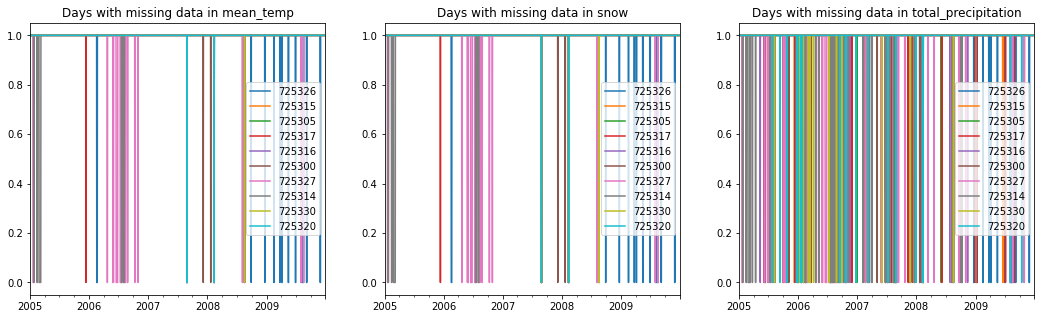

In [6]:
import matplotlib.pyplot as plt
import numpy as np

date_index = pd.date_range(weather_data['date'].min(), weather_data['date'].max())
print(f'We have {len(date_index)} days in the dataset.')
for key, group in weather_data.groupby(['station_number']):
    print(f'Temperature data for station {key} has {len(group.mean_temp)} entries, e.g. data for {len(date_index) - len(group.mean_temp)} days is missing.')

print('Lets see where some of those missing dates are.')

def plot_missing_data(column, axis, weather_data):

    dates = pd.DataFrame(columns=[station for station in weather_data['station_number'].unique()], index=date_index, data=0)
    for key, group in weather_data.groupby(['station_number']):
        dates_with_non_null_mean_temp = weather_data[~weather_data[column].isna()][weather_data['station_number']==key]
        dates.loc[dates_with_non_null_mean_temp['date'].values, key] = 1
    dates.plot(ax=axis)
    axis.set_title(f'Days with missing data in {column}')
    
    
fig, axes = plt.subplots(ncols=3, figsize=(18, 5)) 

plot_missing_data('mean_temp', axes[0], weather_data)
plot_missing_data('snow', axes[1], weather_data)
plot_missing_data('total_precipitation', axes[2], weather_data)
weather_data.head()

Random values are distributed across the dataset and not connected periods of time, so an educated guess would be to fill them with sensible defaults.

For demperature and pressure time series etc., where the process underlying the measurements is continuous and differentiable, I interpolate the missing values. For boolean variables such as snow, I fill them with with values from a timestep before. This does not skewing the overal distribution but it does increase autocorrelation however which will influence our forecasting results. If I was to spend more time on this, I would check by how much and experiment with different filling methods here.

In [7]:
from itertools import product

# Reindex on station_number and date to get continuous time series.
weather_data_reindexed = weather_data.set_index(["station_number", "date"]).reindex(
    pd.MultiIndex.from_product(
        [weather_data["station_number"].unique(), date_index],
        names=["station_number", "date"],
    ),
    fill_value=float('nan')
)

# Interpolate values for variables for which the underlying process is assumed to be smooth.
weather_data_reindexed['mean_temp'].interpolate(inplace=True)
weather_data_reindexed['mean_dew_point'].interpolate(inplace=True)
weather_data_reindexed['mean_sealevel_pressure'].interpolate(limit_directionlimit_direction='both', inplace=True)
weather_data_reindexed['mean_visibility'].interpolate(inplace=True)
weather_data_reindexed['mean_wind_speed'].interpolate(inplace=True)
weather_data_reindexed['max_sustained_wind_speed'].interpolate(inplace=True)
weather_data_reindexed['max_temperature'].interpolate(inplace=True)
weather_data_reindexed['total_precipitation'].interpolate(inplace=True)

# Assume that, if there was snow, they'd report it
weather_data_reindexed['snow_depth'].fillna(value=0, inplace=True)  

# Assume data quality is approximately constant for each station without double checking though.
weather_data_reindexed['num_mean_temp_samples'].fillna(method='ffill', inplace=True)
weather_data_reindexed['num_mean_dew_point_samples'].fillna(method='ffill', inplace=True)
weather_data_reindexed['num_mean_visibility_samples'].fillna(method='ffill', inplace=True)
weather_data_reindexed['num_mean_wind_speed_samples'].fillna(method='ffill', inplace=True)

# Fill with previous value, keeps overall distribution approx. same but increases autocorrelation
weather_data_reindexed['fog'].fillna(method='ffill', inplace=True)
weather_data_reindexed['rain'].fillna(method='ffill', inplace=True)
weather_data_reindexed['snow'].fillna(method='ffill', inplace=True)
weather_data_reindexed['hail'].fillna(method='ffill', inplace=True)
weather_data_reindexed['thunder'].fillna(method='ffill', inplace=True)
weather_data_reindexed['tornado'].fillna(method='ffill', inplace=True)

# Drop columns where there are still nans as data quality is too low.
weather_data_reindexed.dropna(inplace=True, axis=1)

# I suppose, the day of the year could also be a relevant info for the model to guess the likelyhood of snow.
weather_data_reindexed = weather_data_reindexed.reset_index()
weather_data_reindexed['day_of_year'] = weather_data_reindexed['date'].apply(lambda col: pd.Period(col, freq='D').dayofyear)

for column in ['fog', 'rain', 'snow', 'hail', 'thunder', 'tornado']:
    weather_data_reindexed[column] = weather_data_reindexed[column].astype(int)


weather_data_cleaned = weather_data_reindexed
weather_data_cleaned

,station_number,date,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,...,max_temperature,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,day_of_year
0,725326,2005-01-01,29.400000,24.0,20.100000,24.0,10.0,24.0,9.7,24.0,...,21.200001,0.00,0.0,0,0,0,0,0,0,1
1,725326,2005-01-02,38.700001,24.0,35.200001,24.0,6.9,24.0,8.0,24.0,...,32.000000,0.44,0.0,0,0,0,0,0,0,2
2,725326,2005-01-03,31.799999,24.0,28.200001,24.0,7.3,24.0,5.5,24.0,...,28.400000,0.11,0.0,0,0,0,0,0,0,3
3,725326,2005-01-04,28.799999,24.0,25.799999,24.0,6.3,24.0,6.1,24.0,...,28.400000,0.24,0.0,0,0,0,0,0,0,4
4,725326,2005-01-05,24.700001,24.0,20.799999,24.0,4.8,22.0,11.1,24.0,...,21.200001,0.01,0.0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18255,725320,2009-12-27,19.100000,24.0,13.300000,24.0,6.1,24.0,6.0,24.0,...,16.000000,0.04,0.0,1,1,1,1,1,1,361
18256,725320,2009-12-28,23.799999,24.0,16.600000,24.0,9.0,24.0,10.3,24.0,...,15.800000,0.15,0.0,1,1,1,1,1,1,362
18257,725320,2009-12-29,14.700000,24.0,8.200000,24.0,9.7,24.0,3.1,24.0,...,3.000000,0.00,0.0,0,0,0,0,0,0,363
18258,725320,2009-12-30,24.600000,24.0,19.200001,24.0,6.1,24.0,7.5,24.0,...,5.000000,0.03,0.0,1,1,1,1,1,1,364


### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for is the following, and hence should constitute your test set.

In [8]:
from datetime import datetime, timedelta

today_12_years_ago = str(datetime.today()- timedelta(days=12*365)).split(' ')[0]
a_week_ago_12_years_ago = str(datetime.today()- timedelta(days=12*365) - timedelta(days=8)).split(' ')[0]

In [9]:
training_set = weather_data_cleaned[weather_data_cleaned['date']<'2009-09-01']
evaluation_set = weather_data_cleaned[weather_data_cleaned['date']>='2009-09-01']
test_set = weather_data_cleaned[weather_data_cleaned['date']<=today_12_years_ago][weather_data_cleaned['date']>=a_week_ago_12_years_ago]

/tmp/ipykernel_433722/1427600618.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_set = weather_data_cleaned[weather_data_cleaned['date']<=today_12_years_ago][weather_data_cleaned['date']>=a_week_ago_12_years_ago]


In [10]:
from tqdm.notebook import tqdm
import tensorflow as tf

def generate_training_data(training_days: int, dataframe: pd.DataFrame):
    tmp = dataframe.sort_values(['date', 'station_number'])
    tmp_no_dates = tmp.drop(['date', 'station_number'], axis=1)
    date_range = pd.date_range(tmp['date'].min(), tmp['date'].max())
    x_values = []
    y_values = []
    for i in tqdm(range(len(date_range)-(training_days+1))):
        days = date_range[i:i+training_days+1]
        x = tmp_no_dates[dataframe['date'].isin(days[:training_days])].values
        y = tmp_no_dates['snow'][dataframe['date'] == days[-1]].values
        x_values.append([item for sublist in x for item in sublist])
        y_values.append(list(y))
    
    return tf.keras.utils.normalize(x_values, axis=1), tf.keras.utils.normalize(y_values, axis=1)

forecasting_days = 3

x_train, y_train = generate_training_data(forecasting_days,  training_set)
x_eval, y_eval = generate_training_data(forecasting_days, evaluation_set)
x_test, y_test = generate_training_data(forecasting_days, test_set)

2021-11-16 02:37:18.743614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 02:37:18.743647: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


  0%|          | 0/1700 [00:00<?, ?it/s]

/tmp/ipykernel_433722/1311121913.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = tmp_no_dates[dataframe['date'].isin(days[:training_days])].values


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an Algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [12]:
import datetime

str(datetime.datetime.today()- datetime.timedelta(days=12*365)).split(' ')[0]

'2009-11-19'

You are allowed to use any library you are comfortable with such as sklearn, tensorflow keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [13]:


modelNN = tf.keras.models.Sequential()

# Flatten inputs for multiple days
modelNN.add(tf.keras.layers.Flatten())

# Input Layers - relu, because it seems to be a good default
modelNN.add(tf.keras.layers.Dense(len(x_train[0]), activation=tf.nn.relu))

# Hidden Layer
modelNN.add(tf.keras.layers.Dense(2*len(y_train[0]), activation=tf.nn.relu))
modelNN.add(tf.keras.layers.Dense(3*len(y_train[0])//2, activation=tf.nn.relu))

# Output Layer - sigmoid for binary classification
modelNN.add(tf.keras.layers.Dense(len(y_train[0]), activation=tf.nn.relu))


modelNN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6),
    loss='mse',
    metrics=["accuracy"],
)

2021-11-16 02:37:25.692190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-16 02:37:25.692239: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-16 02:37:25.692269: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kolb-ThinkPad-T450s): /proc/driver/nvidia/version does not exist
2021-11-16 02:37:25.692602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
%tensorboard --logdir logs/fit --port=8080

log_dir = "logs/fit/" + 'NN' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

modelNN.fit(
    x_train,
    y_train,
    validation_data=(x_eval, y_eval),
    epochs=1000,
    verbose=0,
    callbacks=[tensorboard_callback],
)

Converging slowly but looking at the evaluation sample shows that its overfitting.

Try a recurring neural network. Maybe that works better for time series data.

In [15]:
def generate_training_data_squences(training_days: int, dataframe: pd.DataFrame):
    tmp = dataframe.sort_values(['date', 'station_number'])
    tmp_no_dates = tmp.drop(['date', 'station_number'], axis=1)
    date_range = pd.date_range(tmp['date'].min(), tmp['date'].max())
    x_values = []
    y_values = []
    for i in tqdm(range(len(date_range)-(training_days+1))):
        days = date_range[i:i+training_days+1]
        x = tmp_no_dates[dataframe['date'].isin(days[:training_days])].values
        y = tmp_no_dates['snow'][dataframe['date'] == days[-1]].values
        
        # don't flatten data for several days but keep it as sqeuences for LSTM
        x_values.append(x)
        y_values.append(y)
    
    return tf.keras.utils.normalize(x_values, axis=1), tf.keras.utils.normalize(y_values, axis=1)

forecasting_days = 7

x_train, y_train = generate_training_data_squences(forecasting_days,  training_set)
x_eval, y_eval = generate_training_data_squences(forecasting_days, evaluation_set)
x_test, y_test = generate_training_data_squences(forecasting_days, test_set)

  0%|          | 0/1696 [00:00<?, ?it/s]

/tmp/ipykernel_433722/1277655004.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = tmp_no_dates[dataframe['date'].isin(days[:training_days])].values


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
x_train[0].shape

(70, 19)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed

modelRNN = Sequential()
modelRNN.add(
    LSTM(128, input_shape=(x_train.shape[1:]), activation="relu", return_sequences=True)
)
modelRNN.add(Dropout(0.2))


modelRNN.add(LSTM(50, activation="relu"))

modelRNN.add(Dense(10, activation="sigmoid"))

In [ ]:

modelRNN.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + 'RNN' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

modelRNN.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_eval, y_eval),
    callbacks=[tensorboard_callback],
)

Epoch 1/100
53/53 [==============================] - 6s 80ms/step - loss: 1.6692 - accuracy: 0.0483 - val_loss: 1.5168 - val_accuracy: 0.0351
Epoch 2/100
53/53 [==============================] - 4s 73ms/step - loss: 1.5239 - accuracy: 0.0448 - val_loss: 1.4610 - val_accuracy: 0.0877
Epoch 3/100
53/53 [==============================] - 5s 95ms/step - loss: 1.6348 - accuracy: 0.0501 - val_loss: 1.5082 - val_accuracy: 0.0351
Epoch 4/100
10/53 [====>.........................] - ETA: 2s - loss: 1.6499 - accuracy: 0.0656